In [26]:
import sys
!{sys.executable} -m pip install --quiet matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = [12, 4]

plt.rcParams["figure.dpi"] = 300

In [2]:
import pandas as pd
from utils_broad import *
from sklearn.metrics import accuracy_score

from tqdm.autonotebook import trange

import tqdm

import numpy as np

torch.Size([10, 50, 1, 16])


In [28]:
path = 'archive'

transform = transforms.Compose([])
train_data = GearboxDataset(path=path, mode='train', model_name= "snn_kaggle_test", transform=transform, data_version="kaggle", is_spiking=True, time_window=50)
spike_loader = DataLoader(train_data, batch_size=10, shuffle=False, num_workers=0, pin_memory=True)

test_spike_data = GearboxDataset(path=path, mode='test', model_name= "snn_kaggle_test", transform=transform, data_version="kaggle", is_spiking=True, time_window=50)
spike_test_loader = DataLoader(test_spike_data, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)

train_data.data.shape

3it [00:00,  6.15it/s]
3it [00:00,  6.66it/s]


torch.Size([4708, 16])

In [29]:
from rockpool.nn.modules import LIFTorch, LIFSlayer
from rockpool.nn.networks.wavesense import WaveSenseNet
from rockpool.nn.networks import SynNet
from rockpool.parameters import Constant

dilations = [2, 32]
n_out_neurons = 2
n_inp_neurons = 16
n_neurons = 32
kernel_size = 2
tau_mem = 0.002
base_tau_syn = 0.002
tau_lp = 0.01
threshold = 1.0
dt = 0.001


# - Use a GPU if available
device = "gpu" if torch.cuda.is_available() else "cpu"
#device = "cpu"

model = WaveSenseNet(
    dilations=dilations,
    n_classes=n_out_neurons,
    n_channels_in=n_inp_neurons,
    n_channels_res=n_neurons,
    n_channels_skip=n_neurons,
    n_hidden=n_neurons,
    kernel_size=kernel_size,
    bias=Constant(0.0),
    smooth_output=True,
    tau_mem=Constant(tau_mem),
    base_tau_syn=base_tau_syn,
    tau_lp=tau_lp,
    threshold=Constant(threshold),
    neuron_model=LIFTorch,
    dt=dt,
).to(device)

size_hidden_layers = [30]
time_constants_per_layer = [5]

model = SynNet(
    n_classes = 2,
    n_channels = 16,
    size_hidden_layers = [30],
    time_constants_per_layer = [5],
    tau_syn_base = 0.002,
    tau_mem = 0.002,
    tau_syn_out = 0.002,
    quantize_time_constants = True,
    threshold = 1.0,
    threshold_out= None,
    train_threshold= False,
    neuron_model = LIFTorch,
    max_spikes_per_dt = 31,
    max_spikes_per_dt_out = 1,
    p_dropout = 0.0,
    dt = 1e-3,
    output = "spikes",
)

model

SynNet  with shape (16, 2) {
    TorchSequential 'seq' with shape (16, 2) {
        LinearTorch '0_LinearTorch' with shape (16, 30)
        LIFTorch '1_LIFTorch' with shape (30, 30)
        TimeStepDropout '2_TimeStepDropout' with shape (30,)
        LinearTorch '3_LinearTorch' with shape (30, 2)
        LIFTorch '4_LIFTorch' with shape (2, 2)
    }
}

In [30]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

crit = CrossEntropyLoss()
opt = Adam(model.parameters().astorch(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.9)

In [31]:
num_epochs = 10

# save loss and accuracy over epochs
losses = []
accs = []


# loop over epochs
t = trange(num_epochs, desc="Training", unit="epoch")
for epoch in trange(num_epochs, desc="Training", unit="epoch"):
    curr_losses = []
    curr_accs = []
    # read one batch of the data
    for inp, tgt in spike_loader:
    #for inp, tgt in dataloader:
        
        # reset states and gradients
        model.reset_state()
        opt.zero_grad()

        # forward path

        inp = (inp * 100).to(torch.int).to(torch.float)
        
        out, _, rec = model(inp.squeeze().to(device), record=True)

        #print(rec.keys())
        # get the last timestep of the output
        # we use the synaptic current of the output layer, as training is more stable
        #out = rec["spk_out"]["isyn"]
        #print(rec.keys())
        out = rec["4_LIFTorch_output"]
        #print(out.shape)

        out_at_last_timestep = out[:, -1, :]

        # pass the last timestep of the output and the target through CE  
        #print(out_at_last_timestep)
        loss = crit(out_at_last_timestep.to(device), tgt.argmax(1).to(device))

        # backward
        loss.backward()

        # apply gradients
        opt.step()
        # save loss and accuracy
        with torch.no_grad():
            pred = out_at_last_timestep.argmax(1)

            #print(tgt.argmax(1), pred.cpu().numpy())

            curr_accs.append(accuracy_score(tgt.argmax(1), pred.cpu().numpy()))
            curr_losses.append(loss.item())

        # print loss and accuracy every 10th epoch
        t.set_postfix({"loss": curr_losses[-1], "acc": curr_accs[-1]})

    losses.append(np.mean(curr_losses))
    accs.append(np.mean(curr_accs))
    print(f'loss:{losses[-1]}, acc:{np.mean(accs[-1])}')

Training:   0%|          | 0/10 [00:00<?, ?epoch/s]

Training:   0%|          | 0/10 [00:00<?, ?epoch/s]

loss:0.6693694585827505, acc:0.5387473460721869
loss:0.42441882316473944, acc:0.8195329087048834
loss:0.3545773613351672, acc:0.9471337579617835
loss:0.34039509555842973, acc:0.9677282377919321
loss:0.3372614121108045, acc:0.9713375796178344
loss:0.3350042583076817, acc:0.9717622080679407
loss:0.3314281354031492, acc:0.9785562632696392
loss:0.332367535103152, acc:0.9785562632696392
loss:0.3336414197447953, acc:0.9738853503184713
loss:0.33502915286461005, acc:0.9738853503184715


In [32]:
# save model

model.save("SynNet_kaggle.json")

In [5]:
# load model

model.load("SynNet_kaggle.json")

In [33]:
acc = []

for inp, tgt in spike_test_loader:
    inp = (inp * 100).to(torch.int).to(torch.float)
    out, _, rec = model(inp.squeeze().to(device), record=True)

    # get the last timestep of the output
    # we use the synaptic current of the output layer, as training is more stable
    out = rec["4_LIFTorch_output"]

    out_at_last_timestep = out[:, -1, :]

    with torch.no_grad():
        pred = out_at_last_timestep.argmax(1)

        acc.append(accuracy_score(tgt.argmax(1), pred.cpu().numpy()))
    

print(f'acc:{np.mean(acc)}')
    

acc:0.9755011135857461


Text(0.5, 0, 'Epoch')

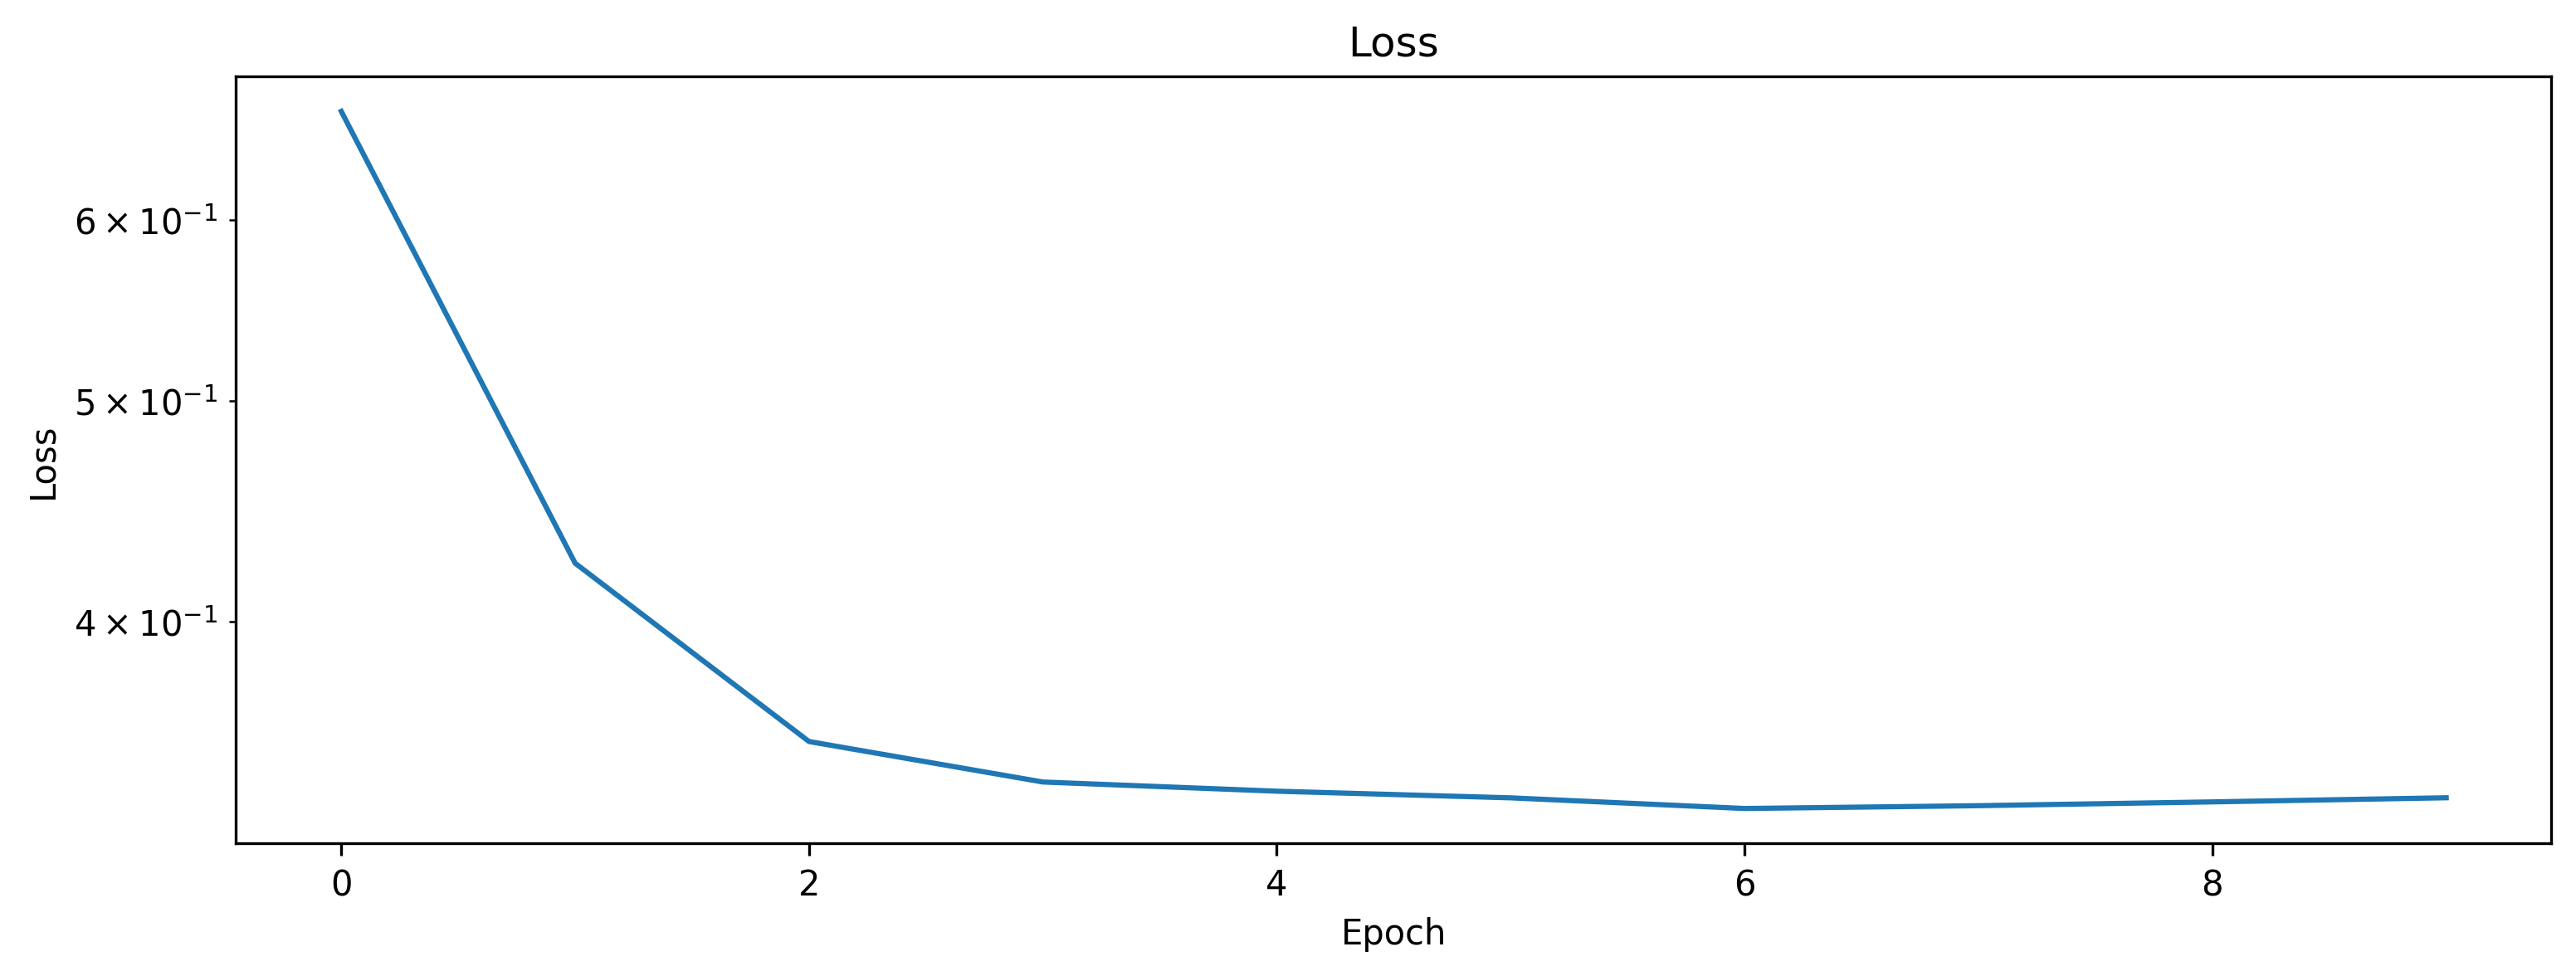

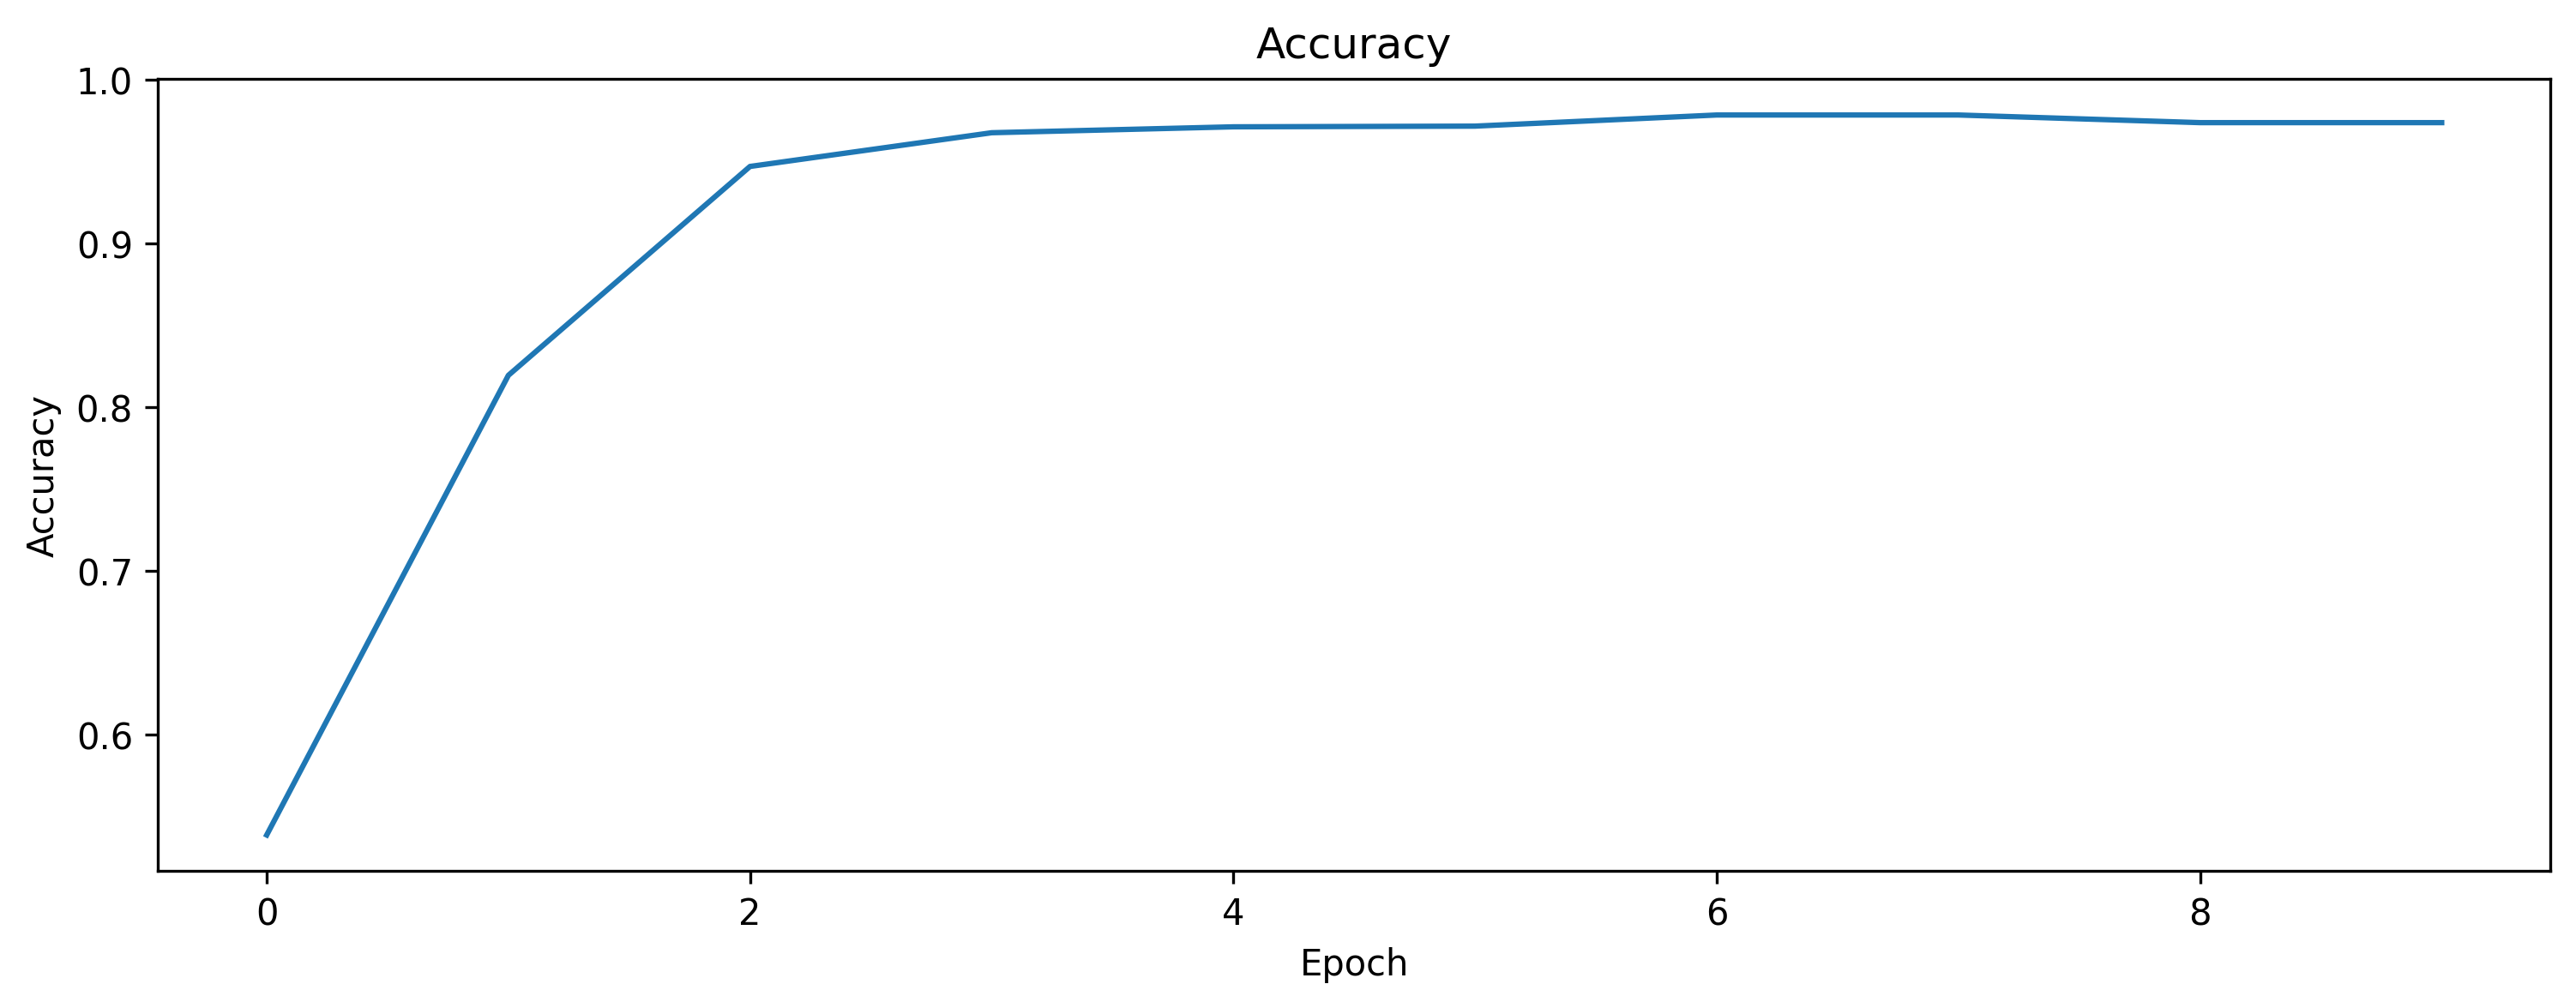

In [34]:
plt.plot(losses)
plt.yscale("log")
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")

plt.figure()
plt.plot(accs)
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")

In [35]:
# - Used to build trainable models
from rockpool.nn.modules import LIFTorch, LinearTorch
from rockpool.nn.combinators import Sequential, Residual
import numpy as np

# - Modules required to interface and deploy models to the Xylo-IMU HDK
from rockpool.devices.xylo import find_xylo_hdks
from rockpool.devices.xylo.syns63300 import XyloSamna, config_from_specification, mapper, XyloSim
import rockpool.devices.xylo.syns63300.xylo_imu_devkit_utils as putils
from rockpool.transform import quantize_methods as q


# - Call the Xylo mapper on the extracted computational graph
spec = mapper(model.as_graph(),  weight_dtype='float', threshold_dtype='float', dash_dtype='float')

# - Quantize the specification
#spec.update(q.global_quantize(**spec))

# # you can also try channel-wise quantization
spec.update(q.channel_quantize(**spec))
# print(spec)
# - Find and connect to a Xylo IMU HDK

xylo_hdk_nodes, modules, versions = find_xylo_hdks()
print(xylo_hdk_nodes, versions)

if len(xylo_hdk_nodes) == 0 or versions[0] is not 'syns63300':
    assert False, 'This tutorial requires a connected Xylo IMU HDK to demonstrate.'
else:
    db = xylo_hdk_nodes[0]
    x = modules[0]


#print(f'Setting Xylo main clock to {x.xylo_imu_devkit_utils.set_xylo_core_clock_freq(db, 6.25)} MHz')

config, is_valid, msg = config_from_specification(**spec)
if not is_valid:
    print(msg)

modSamna = x.XyloSamna(db, config, dt = 0.001, power_frequency=20.)

config

<>:27: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:27: SyntaxWarning: "is not" with a literal. Did you mean "!="?


The connected Xylo HDK contains a Xylo IMU. Importing `rockpool.devices.xylo.syns63300`
[<samna.xyloImuBoards.XyloImuTestBoard object at 0x345d88470>] ['syns63300']


/var/folders/cr/x0bnxh7x43v6qz88_vz0sxmm0000gn/T/ipykernel_64598/3458233530.py:27: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(xylo_hdk_nodes) == 0 or versions[0] is not 'syns63300':


xyloImu::configuration::XyloConfiguration(operation_mode=OperationMode.Manual, bias_enable=1, enable_hibernation_mode=0, time_resolution_wrap=0, hibernation_mode_time_resolution_wrap=0, imu_if_input_enable=0, input=xyloImu::configuration::InputConfig(weight_bit_shift=0, weights={ -114 -30 -33 -77 16 -127 65 -37 48 -2 107 102 11 -47 14 11 11 17 -38 -6 86 127 1 50 73 116 46 -28 19 34 -3 -36 7 -1 9 28 89 -7 11 -38 -126 100 25 0 -5 40 85 -10 -6 -55 35 22 -56 -31 121 79 73 -46 -13 28 -34 127 127 127 -23 45 127 127 -41 127 16 20 -127 -65 127 58 -54 127 127 -127 90 -74 -127 127 -54 61 95 -29 -127 39 122 30 24 39 -82 -25 50 50 0 16 -127 -113 -6 93 -11 -112 56 9 44 -18 79 -50 -31 24 -121 8 -31 52 -24 9 -32 14 -18 -17 -26 90 -24 -20 96 104 51 14 -8 4 38 -55 40 25 12 16 -107 -67 44 -82 7 -103 -75 -104 -13 -42 -63 30 45 -3 -3 49 84 23 24 10 90 -100 -1 48 2 57 -40 -51 -15 -15 123 -98 33 -10 -32 59 -38 62 14 3 -49 -40 -30 -3 9 -72 34 -8 -11 12 22 107 -66 -79 -1 -45 31 -26 -14 -70 117 98 78 -2 -26 -6

Mean Core Power: 0.0009721280052548363
Mean IO Power: 0.0002874143600463867


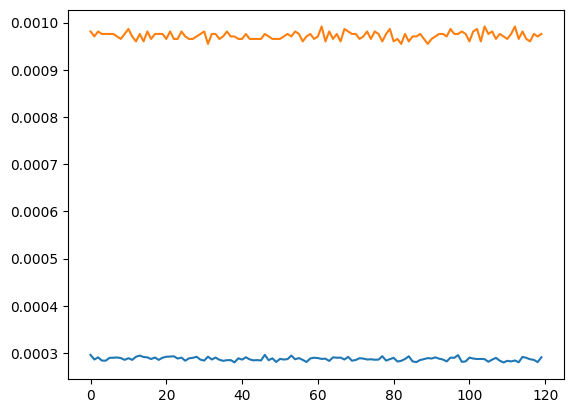

In [2]:
import samna 
from rockpool.devices.xylo.syns63300 import xylo_imu_devkit_utils as hdkutils
from rockpool.devices.xylo.syns63300.xylo_imu_devkit_utils import XyloIMUHDK
import time
import matplotlib.pyplot as plt
import numpy as np
# - Get all recent power events from the power measurement

device_list = samna.device.get_all_devices()

    # - Search for a xylo dev kit
imu_hdk_list = [
    samna.device.open_device(d)
    for d in device_list
    if d.device_type_name == "XyloImuTestBoard"
]

device = imu_hdk_list[0]
power_frequency = 1

power_buf, power = hdkutils.set_power_measure(
            device, power_frequency
)

power.start_auto_power_measurement(power_frequency)

time.sleep(120)

ps = power_buf.get_events()

# - Separate out power meaurement events by channel
channels = samna.xyloImuBoards.MeasurementChannels
io_power = np.array([e.value for e in ps if e.channel == int(channels.Io)])
core_power = np.array(
    [e.value for e in ps if e.channel == int(channels.Core)]
)

power.stop_auto_power_measurement()

plt.plot(io_power)
plt.plot(core_power)

print(f"Mean Core Power: {np.mean(core_power)}")
print(f"Mean IO Power: {np.mean(io_power)}")

In [11]:
print(test_spike_data.data.shape)

torch.Size([1347, 16])


In [37]:
acc = []
i  = 0

for inp, tgt in spike_test_loader:

    if i % 100 == 0:
        print(i)

    i += 1

    inp = (np.array(torch.squeeze(inp).tolist()) * 100).astype(int)

    out, _, record_dict = modSamna(inp, record_power = True)

    with torch.no_grad():
        out_at_last_timestep = out[-1]
        pred = out_at_last_timestep

        acc.append(accuracy_score(tgt.squeeze(), pred))  

print(f'acc:{np.mean(acc)}')

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
acc:0.8240534521158129


In [ ]:
mod = x.XyloIMUMonitor(db, config=config, dt=dt, output_mode="Spike")
data_new, _, _ = mod(np.zeros((5, 3)))

print(data_new)

#plt.plot(data_new[:, 0])

#print(np.mean(data_new[:, 0]))
#print(np.mean(data_new[:, 1]))
#print(np.mean(data_new[:, 2]))